# MODELING TRAFFIC-DENSTIY OF THE CITY OF VIENNA
<i> Part 1: Simulating Paths</i>
***

In this project I attempt to model the traffic-density for the City of Vienna solely based on publicly available data.<br><br>
<b>Data Sources:</b> 
- <u>Road network:</u> The official road network from (https://www.data.gv.at/) consists of information on ~30000 street segments and its respective geolocation and street-type.
- <u>Uber rides:</u> Information on Uber rides per City can be accessed at (https://movement.uber.com/). Uber is splitting the City of Vienna into 1370 subdistricts where travel-time between these starting & ending-areas is reported. Additional categorical information about weekdays or time of the day are available.

<b>Approach:</b><br><br>
<u>Part 1: Simulating Paths</u>
<ul>
    <li>Initialize a network graph consisting of all recorded streets of the City of Vienna</li>
    <li>Map maximum speed-limit to each network edge dependent on its street-type</li>
    <li>Calculate the shortest path of streets between pairs of start/end-nodes in the network</li>
    <li>Collect shortest path information for every start/end combination observed in the set of Uber rides</li>
</ul>

<u>Part 2: Constrained Optimization</u>
<ul>
    <li>Frame a constrained optimiziation problem to derive a "traffic-coefficient" per each area, representing its traffic-density</li>
    <li>Analyze traffic-density per area during different times of the day</li>

<img src="../artifacts/img/cover.jpg" alt="Drawing" style="width: 800px;"/><br>

<center>
    Photo by <a href="https://unsplash.com/@ahmgeek?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Ahmad Tolba</a> on <a href="https://unsplash.com/s/photos/vienna-cars?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
   </center>

### 1 Imports & Settings
***

In [1]:
import os
import sys

root = os.environ['HOME']+"/private/vienna-traffic-density/"
sys.path.append(root)

root_input  = os.path.join(root, "artifacts", "input")
root_output = os.path.join(root, "artifacts", "output")
root_img    = os.path.join(root, "artifacts", "img")

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from matplotlib.patches import Polygon
from shapely.geometry import Polygon as Centroid

from src.network import Network
from src.paths import NetworkPath
from src.streets import Streets
from src.uber_areas import UberAreas
from src.uber_rides import UberRides
from src.utils import plot_graph

### 2 Areas
***

In [3]:
vienna = nx.Graph()
filepath = os.path.join(root_input, "vienna_statistical_areas.json")

areas = UberAreas(
    filepath=filepath, 
    graph=vienna
)


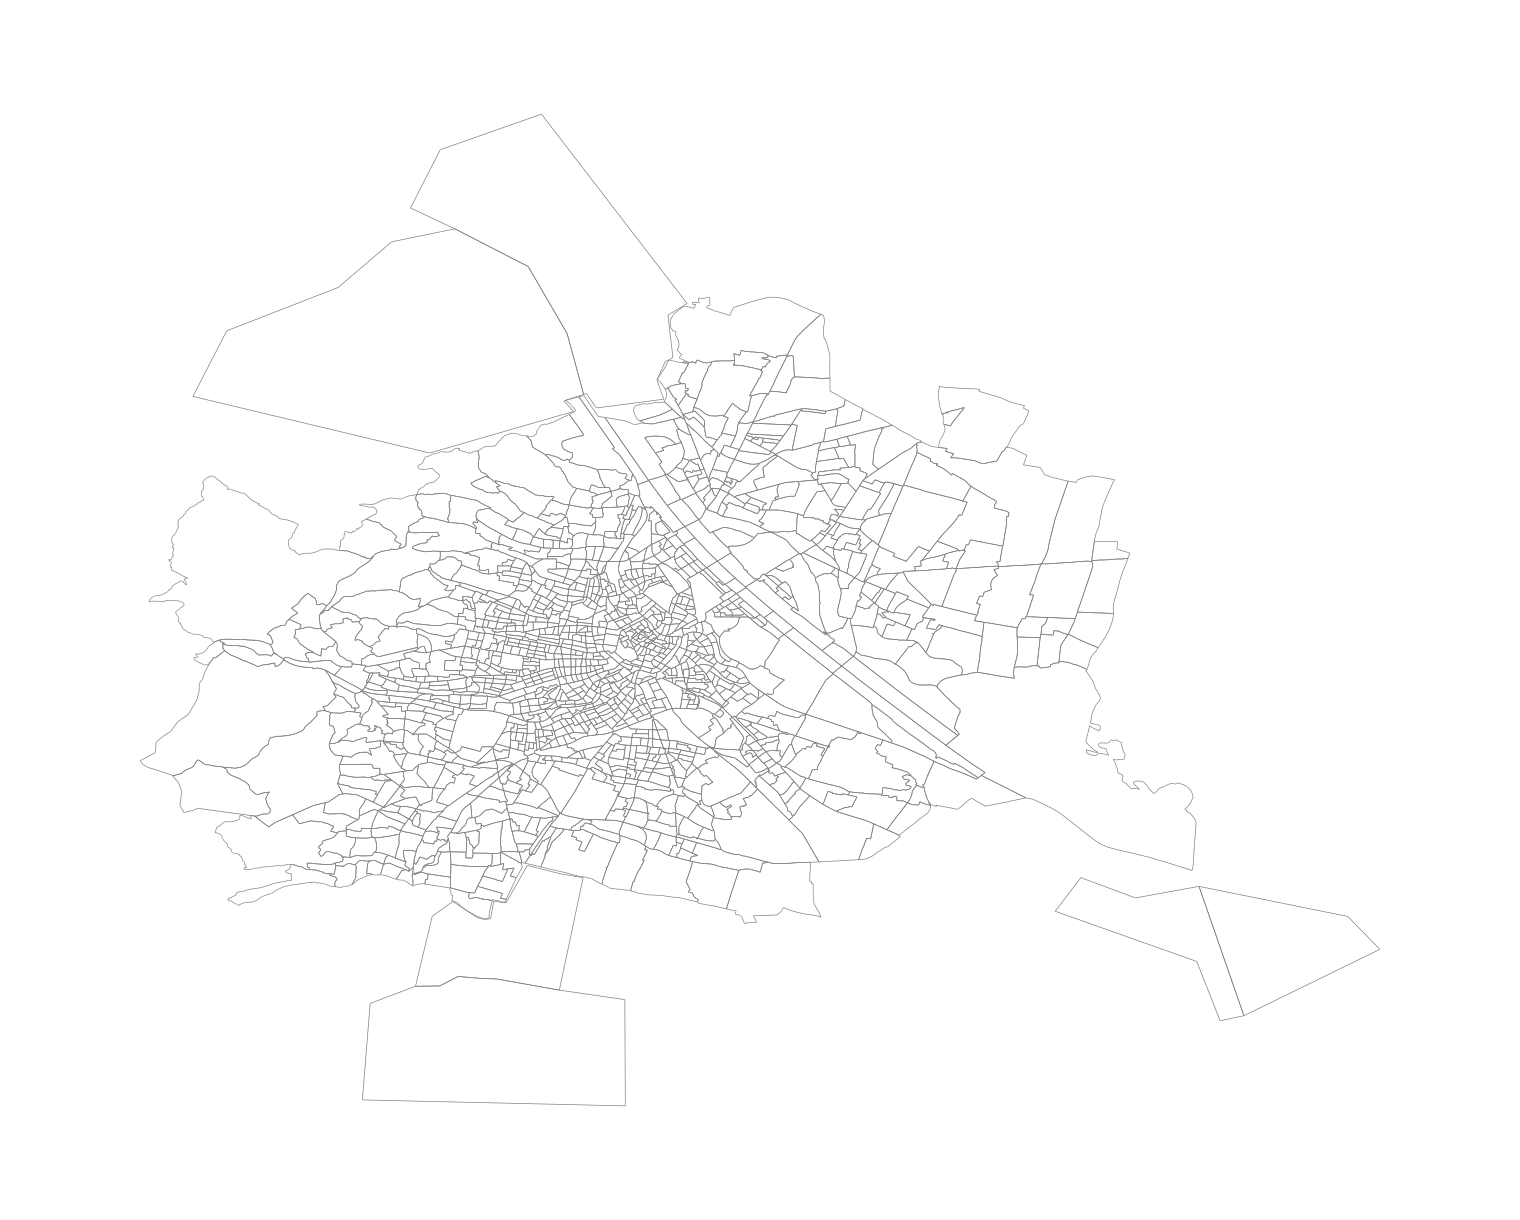

In [4]:
plot_graph(
    G=vienna, 
    pos=areas.pos, 
    colors="grey",
    filename="areas.png"
)

### 3 Streets
***

In [5]:
filepaths = {
    "edges": root_input+"/STRASSENGRAPHOGD.csv",
    "nodes": root_input+"/STRASSENKNOTENOGD.csv"
}

streets = Streets(filepaths=filepaths, polygons=areas.polygons)

In [6]:
# streets.edges.to_csv(root_output+"/edges.csv")
# streets.nodes.to_csv(root_output+"/nodes.csv")

# with open(root_output+"/positions.json", "w") as f:
#     json.dump(streets.positions, f)

# nodes = pd.read_csv(root_output+"/nodes.csv", index_col="id")
# edges = pd.read_csv(root_output+"/edges.csv", index_col="id")

# with open(root_output+"/positions.json", "r") as f:
#     positions = json.load(f, parse_int=int)
#     positions = {int(key): tuple(value) for key, value in positions.items()}

### 4 Network
***

In [7]:
network = Network(
    edges=streets.edges, 
    nodes=streets.nodes
)

In [8]:
# Remove pruned nodes & edges also from streets data
streets.nodes = streets.nodes[~streets.nodes.index.isin(network.disconnected_nodes)]
streets.edges = streets.edges[~streets.edges.index.isin(network.disconnected_edges)]

In [9]:
rand_edge = network.random_edge()
rand_node = network.random_node()

print ("Network-Edges:")
display (network.G.edges[rand_edge])

print ("Network-Nodes:")
display (network.G.nodes[rand_node])

Network-Edges:


{'STREET_NAME': 'Bergenstammgasse',
 'DISTRICT': '13',
 'DISTANCE': 156.30881178332,
 'SPEED': 30,
 'TRAVEL_TIME': 18.757057413998403,
 'STREET_TYPE': 'local-street',
 'AREA_FROM': '0788',
 'AREA_TO': '0788'}

Network-Nodes:


{'AREA': '1055'}

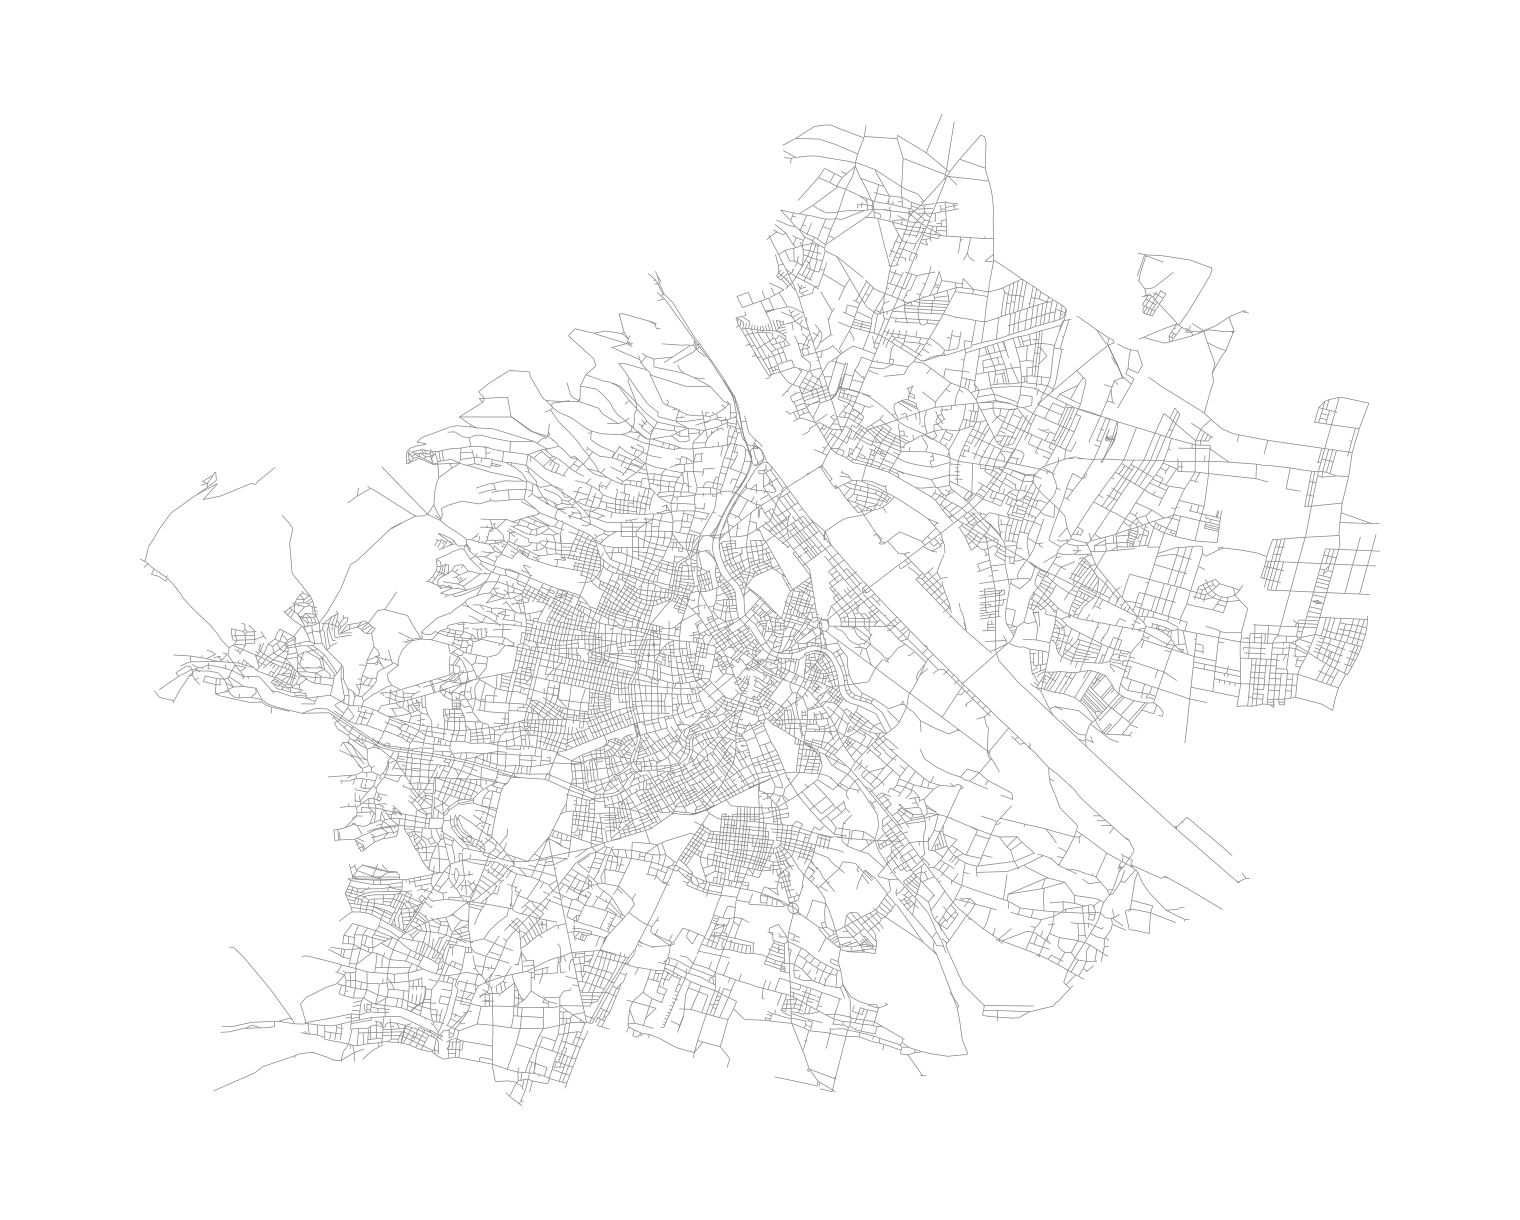

In [10]:
plot_graph(
    G=network.G, 
    pos=streets.pos, 
    colors="gray", 
    filename="streets.png"
)

In [11]:
network.color_by_attr(
    edges=streets.edges, 
    attr="STREET_TYPE"
)
plot_graph(
    G=network.G, 
    pos=streets.pos, 
    colors=network.colors, 
    filedir=root_img,
    filename="streets-type.png"
)

TypeError: plot_graph() got an unexpected keyword argument 'filedir'

### 5 Paths
***

In [ ]:
start_node = network.random_node()
end_node = network.random_node()

print (f"Start-node: {start_node}")
print (f"End-node: {end_node}")

In [ ]:
path = NetworkPath()
path.shortest_path(
    G=network.G,
    start_node=start_node, 
    end_node=end_node,
    metric="TRAVEL_TIME"
)

In [ ]:
network.color_by_path(
    path=path.edges, 
    color="blue", 
)

plot_graph(
    G=network.G, 
    pos=streets.pos, 
    colors=network.colors,
    filedir=root_img, 
    filename="streets-path.png"
)

In [ ]:
path.get_summary(G=network.G)

In [ ]:
print ("Network-Nodes of Path:")
display (path.nodes[:10])

print ("Network-Edges of Path:")
display (path.edges[:10])

In [ ]:
area_counts   = path.get_areas_count(G=network.G)
area_distance = path.get_areas_by_metric(G=network.G, metric="DISTANCE")
area_time     = path.get_areas_by_metric(G=network.G, metric="TRAVEL_TIME")

In [ ]:
plt.figure(figsize=(12,4))
area_counts.plot.bar( 
    ylabel="Number of streets", 
    xlabel="Area",
    title="Areas passed during shortest path"
)

plt.figure(figsize=(12,4))
pd.Series(area_distance).plot.bar(
    ylabel="Distance (in meters)", 
    xlabel="Area",
    title="Distance passed in Areas during Shortest Path"
)

plt.figure(figsize=(12,4))
pd.Series(area_time).plot.bar(
    ylabel="Travel time (in seconds)",
    xlabel="Area",
    title="Time spent in Areas during Shortest Path", 
)
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15))

# Set axis limits for figure
path.get_limits(nodes=streets.nodes)
ax.set_xlim(path.xlim)
ax.set_ylim(path.ylim)

for key,val in areas.polygons.items():
    
    # Plot gray areas
    ax.add_patch(Polygon(val, 
        closed=True, 
        facecolor="lightgray", 
        edgecolor="white",
        linewidth=0.5))
    
    # Plot red areas
    if key in path.areas_set: 
        ax.add_patch(Polygon(val,
            closed=True, 
            facecolor="lightblue", 
            edgecolor="white",
            linewidth=1))
        
        x_center, y_center = Centroid(val).centroid.coords[0]
        ax.text(x=x_center, y=y_center, s=key, ha="center")


# Plot edges of path
for i in range(len(path.nodes)):
    ax.plot(path.x_coords[i:i+2], 
            path.y_coords[i:i+2], 
            linewidth=1, 
            color="blue",
            alpha=0.75,
            marker="x", 
            markersize=6, 
            mfc="blue")

plt.savefig(root_img+"/areas-path.png", dpi=600)
plt.show()

### 6 Uber
***

In [ ]:
areas_in_network = streets.get_all_areas()

In [ ]:
filename = "/vienna-statistical_areas-2020-1-All-DatesByHourBucketsAggregate.csv"
filepath = root_input + filename

uber = UberRides(
    filepath=filepath,
    areas_in_network=areas_in_network,
    nrows=100
)

In [ ]:
uber.data.head()

### 7 Calculate
***

In [ ]:
# Creat empty lists to store path statistics in
path_summary, path_details = list(), list()

iterations = 30

for _, row in uber.data.head(iterations).iterrows():

    start_area = row["sourceid"]
    end_area = row["dstid"]

    # Get median path
    path.get_median_path(
        Streets=streets, 
        G=network.G, 
        metric="TRAVEL_TIME", 
        area_from=start_area, 
        area_to=end_area, 
        sample_size=3
    )
    
    metric = path.get_areas_by_metric(network.G, "TRAVEL_TIME")
    metric = metric.reindex(areas_in_network).fillna(0)
    summary = path.get_summary(network.G)

    path_summary.append(summary)
    path_details.append(metric)
    
# Transform lists/dicts into dataframes to later merge with uber data
path_summary = pd.DataFrame(path_summary)
path_details = pd.DataFrame(path_details)

In [ ]:
path_summary

In [ ]:
path_details

### 8 Export
***

In [ ]:
# # Merge path statistics to uber data
# paths = pd.concat([Uber.data.head(iterations), path_summary, path_details], axis=1)
# paths.to_csv("output/paths.csv", sep=",", index=False)
# paths